# ETNA-TS

In [ ]:
!pip install --upgrade pip
!pip install etna-ts

In [ ]:
!pip install etna

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
original_df = pd.read_csv('/content/drive/MyDrive/Datasets/timeseries/mock_kaggle.csv')

In [ ]:
original_df

,data,venda,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29
...,...,...,...,...
932,2016-07-27,98,3179,2.39
933,2016-07-28,108,3071,2.39
934,2016-07-29,128,4095,2.39
935,2016-07-30,270,3825,2.39


# TSDatset

TSDataset - кастомный pd.DataFrame, котрая имеет такой же табличный вид и некоторые функции

In [ ]:
original_df["timestamp"] = pd.to_datetime(original_df["data"])
original_df["target"] = original_df["venda"]
original_df.drop(columns=["data", "venda","preco","estoque"], inplace=True)
original_df["segment"] = "main"
original_df.head()

,timestamp,target,segment
0,2014-01-01,0,main
1,2014-01-02,70,main
2,2014-01-03,59,main
3,2014-01-04,93,main
4,2014-01-05,96,main


Библиотека работает с временными рядамами вида timestamp - target - segment(То есть столбцы должны имееть именно такое название)

In [ ]:
from etna.datasets.tsdataset import TSDataset
df = TSDataset.to_dataset(original_df)
df

segment,main
feature,target
timestamp,
2014-01-01,0
2014-01-02,70
2014-01-03,59
2014-01-04,93
2014-01-05,96
...,...
2016-07-27,98
2016-07-28,108


In [ ]:
ts = TSDataset(df, freq='D')

TSDataset имеет встроенную функцию визуализации временных рядов

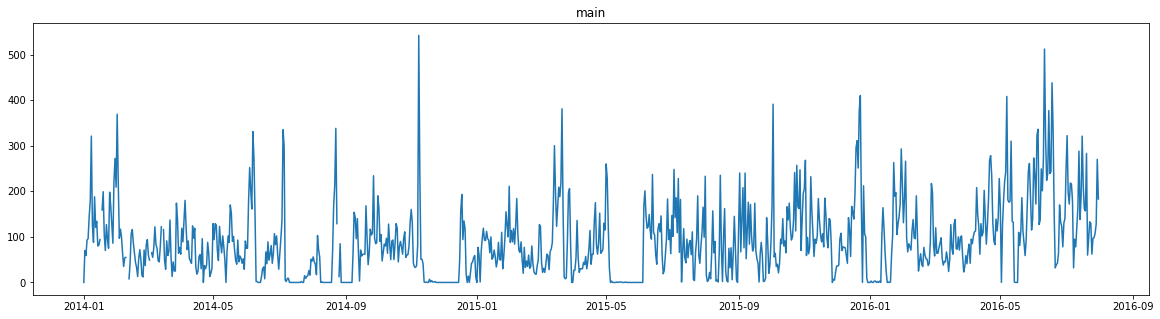

In [ ]:
ts.plot()

# Cross-val

В библиотеке реализована классическая версия кросс-валидации для временных рядов

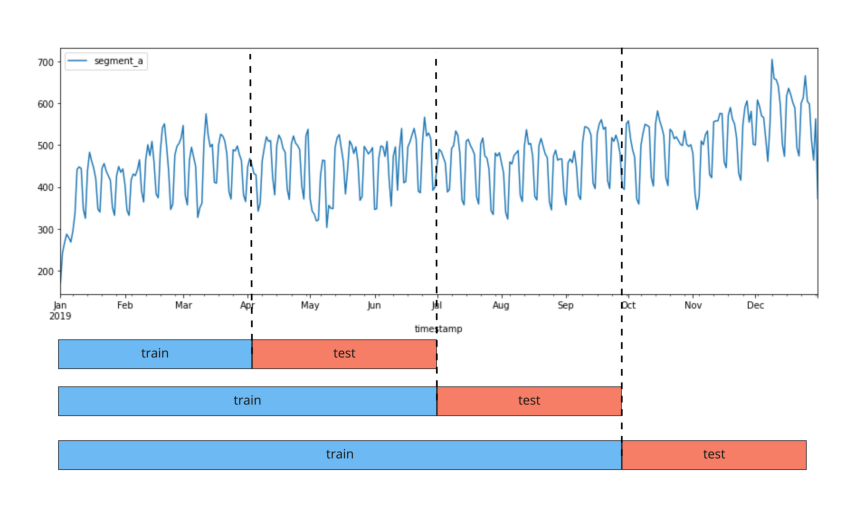

In [ ]:
from etna.models import NaiveModel
HORIZON = 31
model = NaiveModel(lag=12)

In [ ]:
from etna.model_selection.backtest import CrossValidationMode,TimeSeriesCrossValidation
from etna.metrics import SMAPE,MAE,MSE
tscv = TimeSeriesCrossValidation(model=model, horizon=HORIZON, metrics=[MAE(), MSE(), SMAPE()])
metrics_df, forecast_df, fold_info_df = tscv.backtest(ts=ts)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


Метрики по каждому фолду

In [ ]:
metrics_df

,segment,MAE,MSE,SMAPE,fold_number
0,main,45.387097,4054.290323,56.132036,0
0,main,64.387097,8601.548387,56.630422,1
0,main,89.258065,15875.451613,62.951734,2
0,main,121.709677,25331.000000,67.374179,3
0,main,91.548387,14664.645161,68.441176,4


In [ ]:
forecast_df.head()

segment      main            
feature    target fold_number
timestamp                    
2016-02-28   47.0           0
2016-02-29   63.0           0
2016-03-01   39.0           0
2016-03-02   35.0           0
2016-03-03   77.0           0

Информация по каждому фолду

In [ ]:
fold_info_df.head()

,train_start_time,train_end_time,test_start_time,test_end_time,fold_number
0,2014-01-01,2016-02-27,2016-02-28,2016-03-29,0
0,2014-01-01,2016-03-29,2016-03-30,2016-04-29,1
0,2014-01-01,2016-04-29,2016-04-30,2016-05-30,2
0,2014-01-01,2016-05-30,2016-05-31,2016-06-30,3
0,2014-01-01,2016-06-30,2016-07-01,2016-07-31,4


In [ ]:
tscv.get_metrics(aggregate_metrics=True)

,segment,MAE,MSE,SMAPE
0,main,82.458065,13705.387097,62.30591


# Analysis


В библиотеке реализовано мнодество методов для визуального анадиза временных рядов

In [ ]:
from etna.analysis.eda_utils import cross_corr_plot,distribution_plot,sample_pacf_plot
from etna.analysis.outliers import density_outliers,hist_outliers,median_outliers,sequence_outliers,get_anomalies_median, get_anomalies_density
from etna.analysis.plotters import plot_anomalies,plot_backtest,plot_forecast
from etna.analysis.outliers.confidence_interval_outliers import get_anomalies_confidence_interval

Распределенние по выбранному интервалу

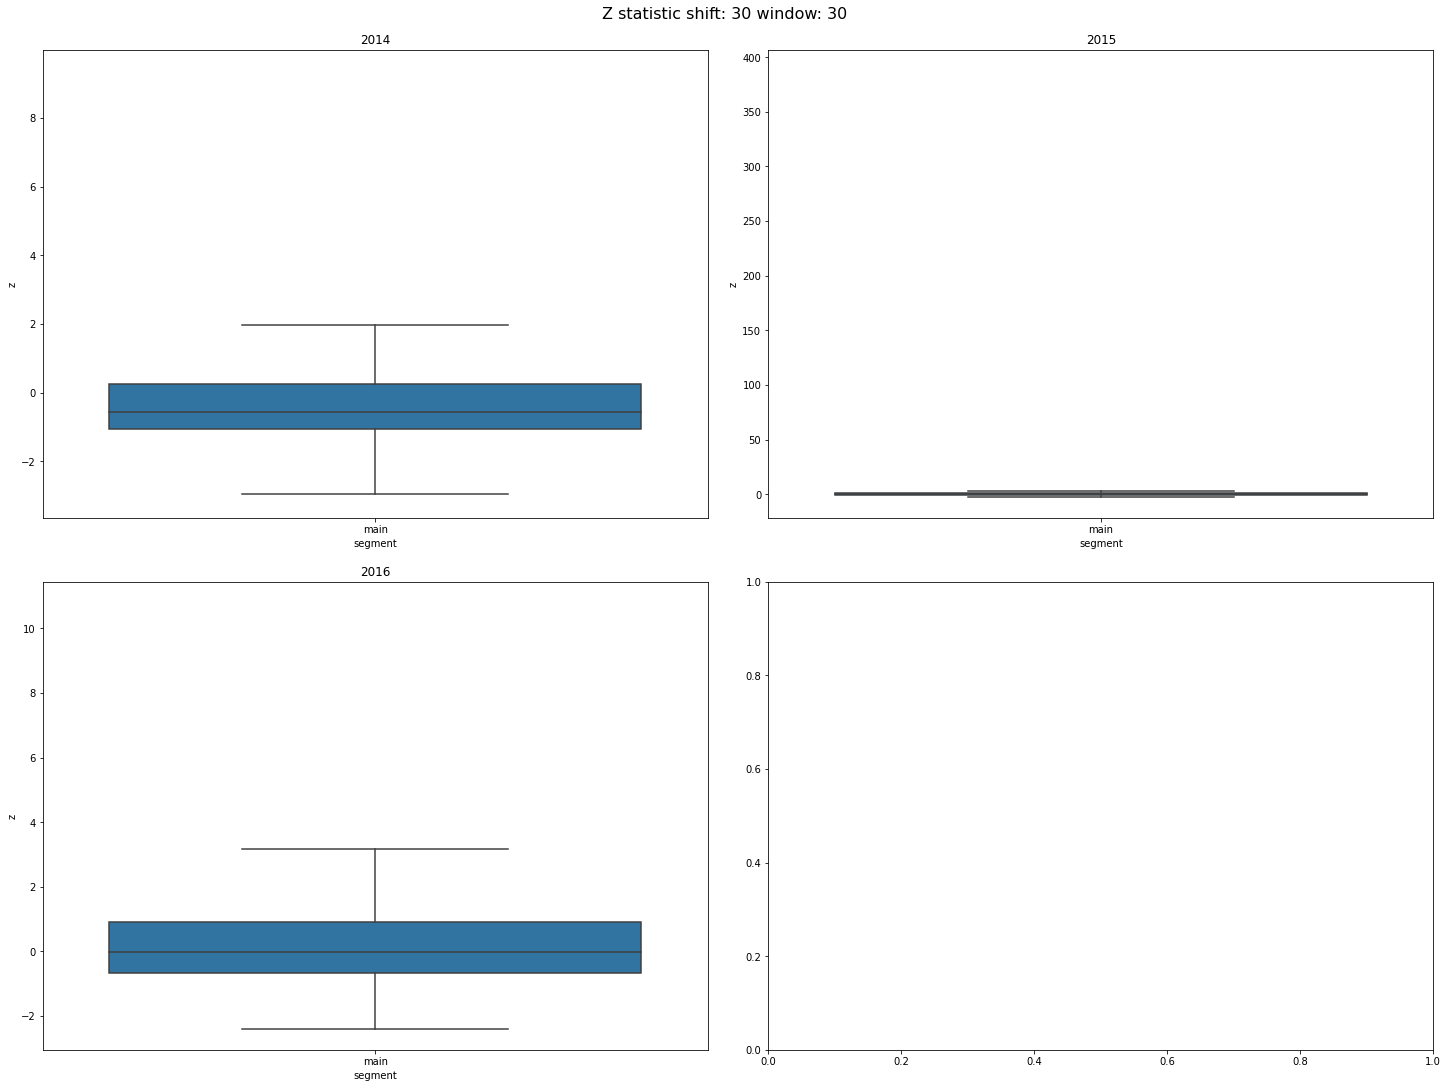

In [ ]:
distribution_plot(ts,n_segments=1,n_rows=2, freq="1Y")

Функция частичной автокорреляции

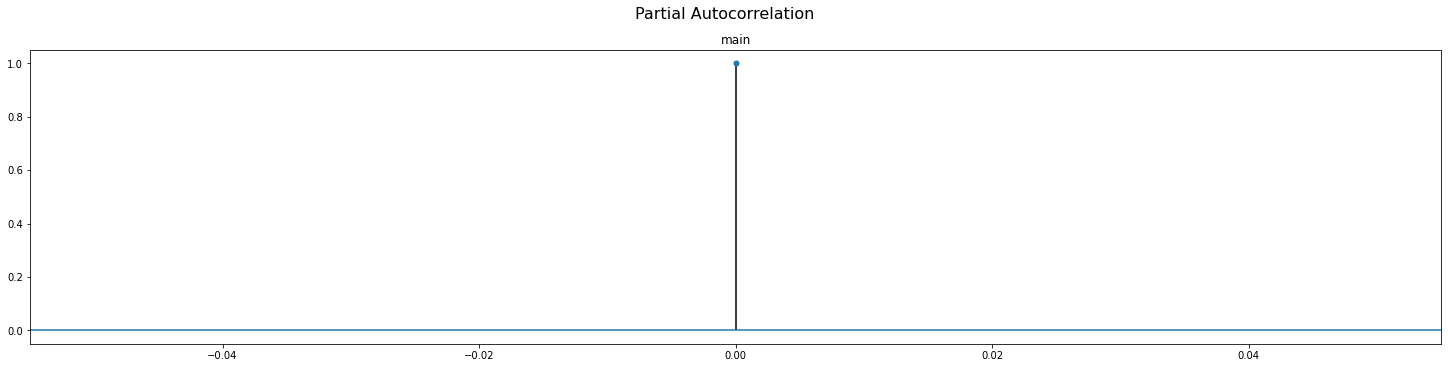

In [ ]:
sample_pacf_plot(ts,lags=21)

Визуализация выбросов

Медианный метод

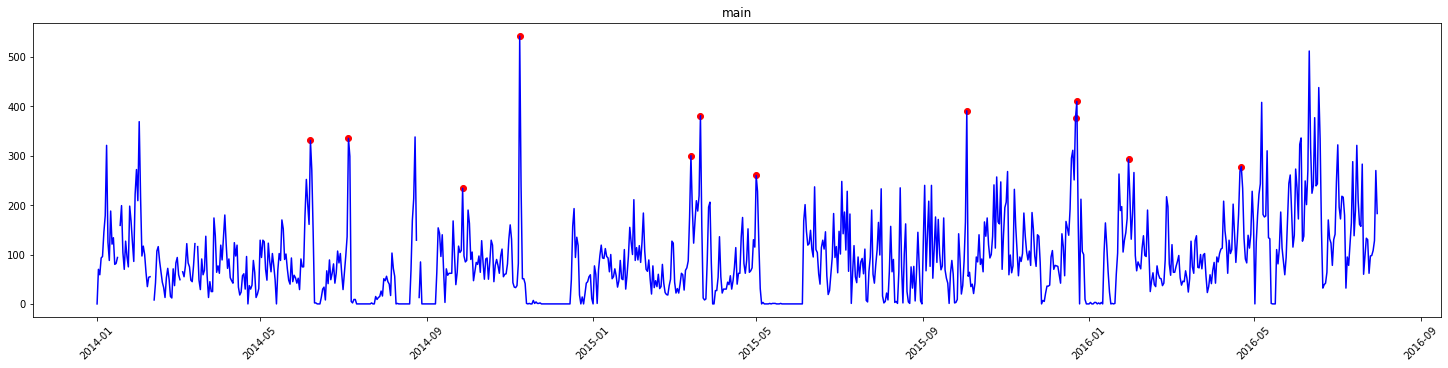

In [ ]:
anomaly_dict = get_anomalies_median(ts, window_size=50)
plot_anomalies(ts, anomaly_dict)


Метод основанный на расстоянии (можно задать кастомную функцию расстояния)

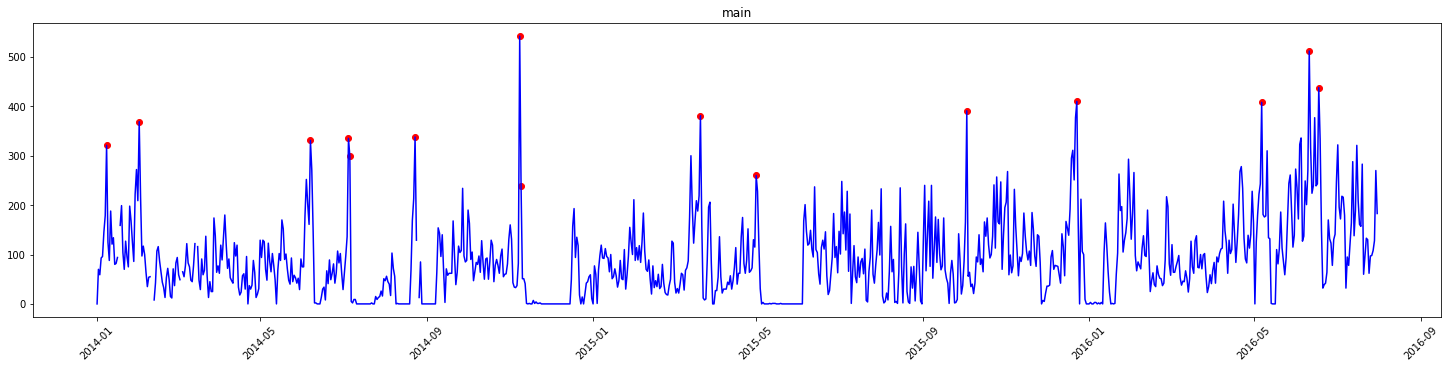

In [ ]:
anomaly_dict = get_anomalies_density(ts, window_size=20, n_neighbors=3)
plot_anomalies(ts, anomaly_dict)

Обнаружение послежовательности выбросов

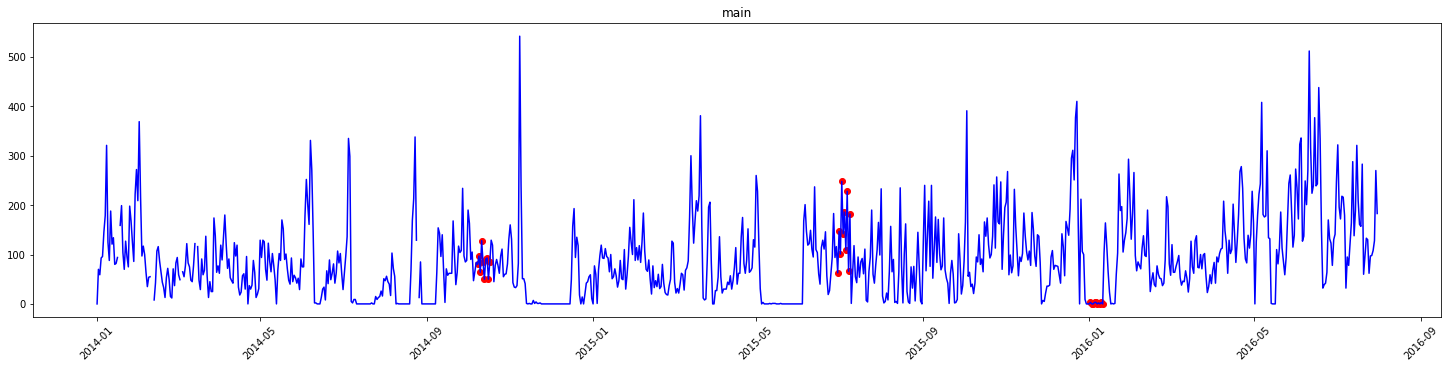

In [ ]:
anomaly_seq_dict = sequence_outliers.get_sequence_anomalies(ts, num_anomalies = 3, anomaly_length = 10)
plot_anomalies(ts, anomaly_seq_dict)

# Transforms

Огромную часть библиотеки составляют трансформы, специальные функции, которые используются для генерации новых признаков, как из даты, так и из таргета

In [ ]:
import warnings
# from etna.transforms.scalers import MinMaxScalerTransform,MaxAbsScalerTransform,RobustScalerTransform,StandardScalerTransform
from etna.transforms.statistics import StdTransform,MinTransform,MedianTransform,MaxTransform
from etna.transforms import MeanTransform, LagTransform, LogTransform, MeanTransform,SegmentEncoderTransform, DateFlagsTransform, LinearTrendTransform
from etna.transforms.trend import TrendTransform
from etna.transforms.detrend import TheilSenTrendTransform,LinearTrendTransform
from etna.transforms.imputation import TimeSeriesImputerTransform


warnings.filterwarnings("ignore")

log = LogTransform(in_column="target")

seg = SegmentEncoderTransform()

lags = LagTransform(in_column="target", lags=list(range(30, 96, 1)))
d_flags = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=True,
    week_number_in_month=True,
    week_number_in_year=True,
    month_number_in_year=True,
    year_number=True,
    special_days_in_week=[5, 6])
mean30 = MeanTransform(in_column="target", window=30, out_postfix="_mean30")
minmax = MinMaxScalerTransform()
imputer = TimeSeriesImputerTransform(in_column = 'target',strategy='mean')
maxabs = MaxAbsScalerTransform()
robust = RobustScalerTransform()
standart = StandardScalerTransform()
max30 = MaxTransform(in_column="target", window=30, out_postfix="_max30")
med30 = MedianTransform(in_column="target", window=30, out_postfix="_med30")
min30 = MinTransform(in_column="target", window=30, out_postfix="_min30")
std30 = StdTransform(in_column="target", window=30, out_postfix="_std30")
trend = TrendTransform(in_column='target')
theil_trend = TheilSenTrendTransform(in_column='target')
lin_trend = LinearTrendTransform(in_column='target')

In [ ]:
def log_ts():
  ts = TSDataset(df, freq='D')
  ts.fit_transform([log])
  ts.df.rename(columns = {'target': 'target_log'}, inplace = True)
  return ts
log_df = log_ts()

def lin_trend_ts():
  ts = TSDataset(df, freq='D')
  ts.fit_transform([imputer])
  ts.fit_transform([lin_trend])
  ts.df.rename(columns = {'target': 'target_lintrend'}, inplace = True)
  return ts
lin_trend_df = lin_trend_ts()

def theil_trend_ts():
  ts = TSDataset(df, freq='D')
  ts.fit_transform([imputer])
  ts.fit_transform([theil_trend])
  ts.df.rename(columns = {'target': 'target_theil'}, inplace = True)
  return ts
theil_trend_df = theil_trend_ts()

def trend_ts():
  ts = TSDataset(df, freq='D')
  ts.fit_transform([imputer])
  ts.fit_transform([trend])
  ts.df.rename(columns = {'target': 'target_trend'}, inplace = True)
  return ts
#trend_df = trend_ts()

def std30_ts():
  ts = TSDataset(df, freq='D')
  ts.fit_transform([std30])

  return ts
std30_df = std30_ts()

def min30_ts():
  ts = TSDataset(df, freq='D')
  ts.fit_transform([min30])

  return ts
min30_df = min30_ts()

def med30_ts():
  ts = TSDataset(df, freq='D')
  ts.fit_transform([med30])

  return ts
med30_df = med30_ts()

def max30_ts():
  ts = TSDataset(df, freq='D')
  ts.fit_transform([max30])

  return ts
max30_df = max30_ts()

def standart_ts():
  ts = TSDataset(df, freq='D')
  ts.fit_transform([standart])
  ts.df.rename(columns = {'target': 'target_standart'}, inplace = True)
  return ts
standart_df = standart_ts()

def robust_ts():
  ts = TSDataset(df, freq='D')
  ts.fit_transform([robust])
  ts.df.rename(columns = {'target': 'target_robust'}, inplace = True)
  return ts
robust_df = robust_ts()

def maxabs_ts():
  ts = TSDataset(df, freq='D')
  ts.fit_transform([maxabs])
  ts.df.rename(columns = {'target': 'target_maxabs'}, inplace = True)
  return ts
maxabs_df = maxabs_ts()

def minmax_ts():
  ts = TSDataset(df, freq='D')
  ts.fit_transform([minmax])
  ts.df.rename(columns = {'target': 'target_minmax'}, inplace = True)
  return ts
minmax_df = minmax_ts()

def mean30_ts():
  ts = TSDataset(df, freq='D')
  ts.fit_transform([mean30])
  return ts
mean30_df = mean30_ts()

def d_flags_ts():
  ts = TSDataset(df, freq='D')
  ts.fit_transform([d_flags])
  ts.df.rename(columns = {'target': 'target_dflag'}, inplace = True)
  return ts
d_flags_df = d_flags_ts()

def lags_ts():
  ts = TSDataset(df, freq='D')
  print(type(ts))
  ts.fit_transform([lags])
  ts.df.rename(columns = {'target': 'target_lag'}, inplace = True)
  return ts
lags_df = lags_ts()

def seg_ts():
  ts = TSDataset(df, freq='D')
  ts.fit_transform([seg])
  ts.df.rename(columns = {'target': 'target_seg'}, inplace = True)
  return ts
seg_df = seg_ts()

<class 'etna.datasets.tsdataset.TSDataset'>


In [ ]:
lags_df

segment          main                ...                            
feature    target_lag target_lag_30  ... target_lag_94 target_lag_95
timestamp                            ...                            
2014-01-01        0.0           NaN  ...           NaN           NaN
2014-01-02       70.0           NaN  ...           NaN           NaN
2014-01-03       59.0           NaN  ...           NaN           NaN
2014-01-04       93.0           NaN  ...           NaN           NaN
2014-01-05       96.0           NaN  ...           NaN           NaN
...               ...           ...  ...           ...           ...
2016-07-27       98.0         123.0  ...         133.0         234.0
2016-07-28      108.0          78.0  ...          91.0         133.0
2016-07-29      128.0         130.0  ...          83.0          91.0
2016-07-30      270.0         141.0  ...         139.0          83.0
2016-07-31      183.0         247.0  ...         113.0         139.0

[943 rows x 67 columns]

Логарифмическое преобразование таргета

In [ ]:
log_df

segment,main
feature,target_log
timestamp,
2014-01-01,0.000000
2014-01-02,1.851258
2014-01-03,1.778151
2014-01-04,1.973128
2014-01-05,1.986772
...,...
2016-07-27,1.995635
2016-07-28,2.037426


Вынести из даты определнные константные данные(день недели, номер недели в месяце и тд.)

In [ ]:
d_flags_df

segment                   main  ...            
feature    day_number_in_month  ... year_number
timestamp                       ...            
2014-01-01                   1  ...        2014
2014-01-02                   2  ...        2014
2014-01-03                   3  ...        2014
2014-01-04                   4  ...        2014
2014-01-05                   5  ...        2014
...                        ...  ...         ...
2016-07-27                  27  ...        2016
2016-07-28                  28  ...        2016
2016-07-29                  29  ...        2016
2016-07-30                  30  ...        2016
2016-07-31                  31  ...        2016

[943 rows x 8 columns]

Минимаксное преобразование таргета(sklearn)

In [ ]:
minmax_df

segment,main
feature,target_minmax
timestamp,
2014-01-01,0.000000
2014-01-02,0.129151
2014-01-03,0.108856
2014-01-04,0.171587
2014-01-05,0.177122
...,...
2016-07-27,0.180812
2016-07-28,0.199262


Максимальное абсолютное значение таргета(sklearn)

In [ ]:
maxabs_df

segment,main
feature,target_maxabs
timestamp,
2014-01-01,0.000000
2014-01-02,0.129151
2014-01-03,0.108856
2014-01-04,0.171587
2014-01-05,0.177122
...,...
2016-07-27,0.180812
2016-07-28,0.199262


Робастное преобразование таргета(sklearn)

In [ ]:
robust_df

segment,main
feature,target_robust
timestamp,
2014-01-01,-0.808511
2014-01-02,-0.063830
2014-01-03,-0.180851
2014-01-04,0.180851
2014-01-05,0.212766
...,...
2016-07-27,0.234043
2016-07-28,0.340426


Стандартизация таргета(sklearn)

In [ ]:
standart_df

segment,main
feature,target_standart
timestamp,
2014-01-01,-1.122702
2014-01-02,-0.254636
2014-01-03,-0.391047
2014-01-04,0.030585
2014-01-05,0.067788
...,...
2016-07-27,0.092590
2016-07-28,0.216600


Среднее значение таргета по окну

In [ ]:
mean30_df

segment      main               
feature    target target__mean30
timestamp                       
2014-01-01    0.0       0.000000
2014-01-02   70.0       0.000000
2014-01-03   59.0      35.000000
2014-01-04   93.0      43.000000
2014-01-05   96.0      55.500000
...           ...            ...
2016-07-27   98.0     161.300000
2016-07-28  108.0     160.466667
2016-07-29  128.0     161.466667
2016-07-30  270.0     161.400000
2016-07-31  183.0     165.700000

[943 rows x 2 columns]

Максимальное значение таргета по окну

In [ ]:
max30_df

segment      main              
feature    target target__max30
timestamp                      
2014-01-01    0.0           0.0
2014-01-02   70.0           0.0
2014-01-03   59.0          70.0
2014-01-04   93.0          70.0
2014-01-05   96.0          93.0
...           ...           ...
2016-07-27   98.0         322.0
2016-07-28  108.0         322.0
2016-07-29  128.0         322.0
2016-07-30  270.0         322.0
2016-07-31  183.0         322.0

[943 rows x 2 columns]

Минимальное значение таргета по окну

In [ ]:
min30_df

segment      main              
feature    target target__min30
timestamp                      
2014-01-01    0.0           0.0
2014-01-02   70.0           0.0
2014-01-03   59.0           0.0
2014-01-04   93.0           0.0
2014-01-05   96.0           0.0
...           ...           ...
2016-07-27   98.0          32.0
2016-07-28  108.0          32.0
2016-07-29  128.0          32.0
2016-07-30  270.0          32.0
2016-07-31  183.0          32.0

[943 rows x 2 columns]

Медианное значение таргета по окну

In [ ]:
med30_df

segment      main              
feature    target target__med30
timestamp                      
2014-01-01    0.0           0.0
2014-01-02   70.0           0.0
2014-01-03   59.0          35.0
2014-01-04   93.0          59.0
2014-01-05   96.0          64.5
...           ...           ...
2016-07-27   98.0         149.0
2016-07-28  108.0         149.0
2016-07-29  128.0         149.0
2016-07-30  270.0         149.0
2016-07-31  183.0         159.0

[943 rows x 2 columns]

Стандартное отклонение таргета по окну

In [ ]:
std30_df

segment      main              
feature    target target__std30
timestamp                      
2014-01-01    0.0      0.000000
2014-01-02   70.0      0.000000
2014-01-03   59.0     49.497475
2014-01-04   93.0     37.643060
2014-01-05   96.0     39.619019
...           ...           ...
2016-07-27   98.0     76.660087
2016-07-28  108.0     77.224587
2016-07-29  128.0     76.308689
2016-07-30  270.0     76.337996
2016-07-31  183.0     78.744524

[943 rows x 2 columns]

 Значение тренда с помощью многомерной регрессии(sklearn)

In [ ]:
theil_trend_df

segment,main
feature,target_theil
timestamp,
2014-01-01,-36.827456
2014-01-02,33.116733
2014-01-03,22.060922
2014-01-04,56.005112
2014-01-05,58.949301
...,...
2016-07-27,8.822242
2016-07-28,18.766431


Значение тренда с помощью линейной регрисии(sklearn)

In [ ]:
lin_trend_df

segment,main
feature,target_lintrend
timestamp,
2014-01-01,-54.217239
2014-01-02,15.705657
2014-01-03,4.628552
2014-01-04,38.551447
2014-01-05,41.474342
...,...
2016-07-27,-28.541578
2016-07-28,-18.618683


# Models

In [ ]:
train_ts, test_ts = ts.train_test_split(train_start='2014-01-01',
                                        train_end='2016-06-30',
                                        test_start='2016-07-01',
                                        test_end='2016-07-31')

In [ ]:
train_ts.fit_transform([d_flags])
test_ts.fit_transform([d_flags])


In [ ]:
def get_metrics(forecast,test):
    """Compute the metrics on forecast"""
    metrics = {"MAE":MAE(),"MSE":MSE(),"SMAPE":SMAPE()}
    results = dict()
    for name,metric in metrics.items():
      results[name] = metric(y_true=test, y_pred=forecast)
    return results

Сезонное скользящее среднее

{'MAE': {'main': 61.18823451612904},
 'MSE': {'main': 5718.950623370828},
 'SMAPE': {'main': 39.353534047253525}}

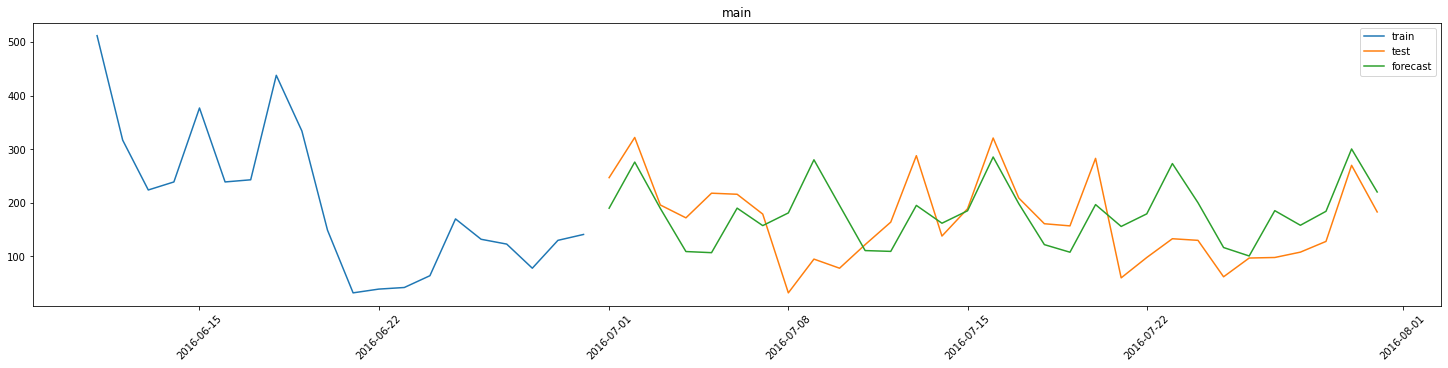

In [ ]:
from etna.models import SeasonalMovingAverageModel
def SeasonalMovingAverageModel_p(train_ts,test_ts):
  model = SeasonalMovingAverageModel(window=10)
  model.fit(train_ts)

#Make the forecast
  future_ts = train_ts.make_future(HORIZON)
  forecast_ts = model.forecast(future_ts)
  metric = get_metrics(forecast_ts,test_ts)
  plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=20)
  return metric
SeasonalMovingAverageModel_p(train_ts,test_ts)

Наивная баесовская модель

{'MAE': {'main': 91.54838709677419},
 'MSE': {'main': 14664.645161290322},
 'SMAPE': {'main': 68.44117646119687}}

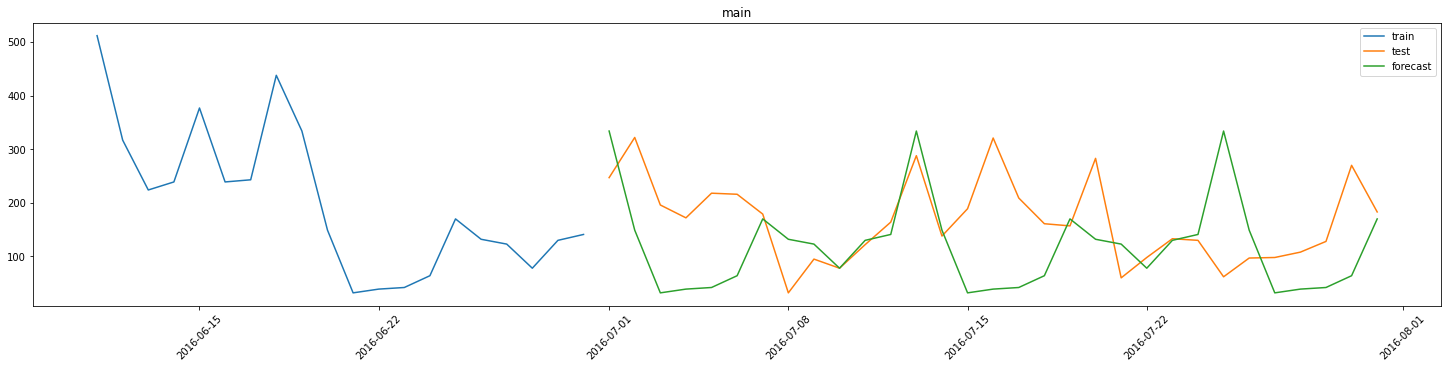

In [ ]:
HORIZON = 31
from etna.models import NaiveModel
from etna.analysis import plot_forecast
def NaiveModel_p(train_ts,test_ts):
  #Fit the model
  model = NaiveModel(lag=12)
  model.fit(train_ts)

  #Make the forecast
  future_ts = train_ts.make_future(HORIZON)
  forecast_ts = model.forecast(future_ts)
  metric = get_metrics(forecast_ts,test_ts)
  plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=20)
  return metric
NaiveModel_p(train_ts,test_ts)

Facebook's Prophet model

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


{'MAE': {'main': 64.06273902148908},
 'MSE': {'main': 6010.1138781941945},
 'SMAPE': {'main': 41.40418042874284}}

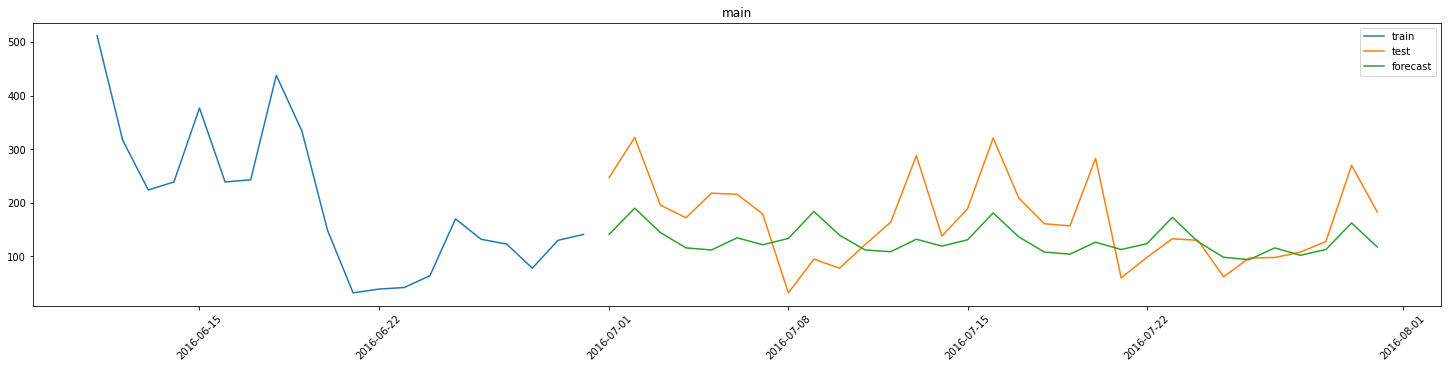

In [ ]:
from etna.models import ProphetModel
def ProphetModel_p(train_ts,test_ts):
  model = ProphetModel()
  model.fit(train_ts)

#Make the forecast
  future_ts = train_ts.make_future(HORIZON)
  forecast_ts = model.forecast(future_ts)
  metric = get_metrics(forecast_ts,test_ts)
  plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=20)
  return metric
ProphetModel_p(train_ts,test_ts)

Эластикнет модель(sklearn) (м)

{'MAE': {'main': 76.03313674780175},
 'MSE': {'main': 9291.745164283473},
 'SMAPE': {'main': 50.861558625124644}}

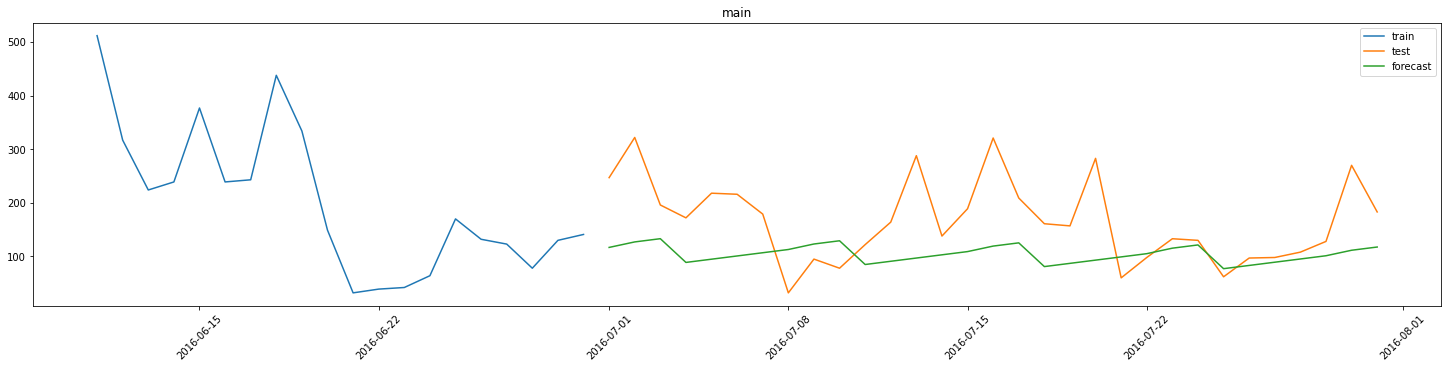

In [ ]:
from etna.models import ElasticPerSegmentModel
def ElasticPerSegmentModel_p(train_ts,test_ts):
  model = ElasticPerSegmentModel()
  model.fit(train_ts)  
#Make the forecast
  future_ts = train_ts.make_future(HORIZON)
  forecast_ts = model.forecast(future_ts)
  metric = get_metrics(forecast_ts,test_ts)
  plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=20)
  return metric
ElasticPerSegmentModel_p(train_ts,test_ts)

Линейная регрессия (sklearn) (m)

{'MAE': {'main': 66.58789148230098},
 'MSE': {'main': 7185.969640440043},
 'SMAPE': {'main': 43.04361762508908}}

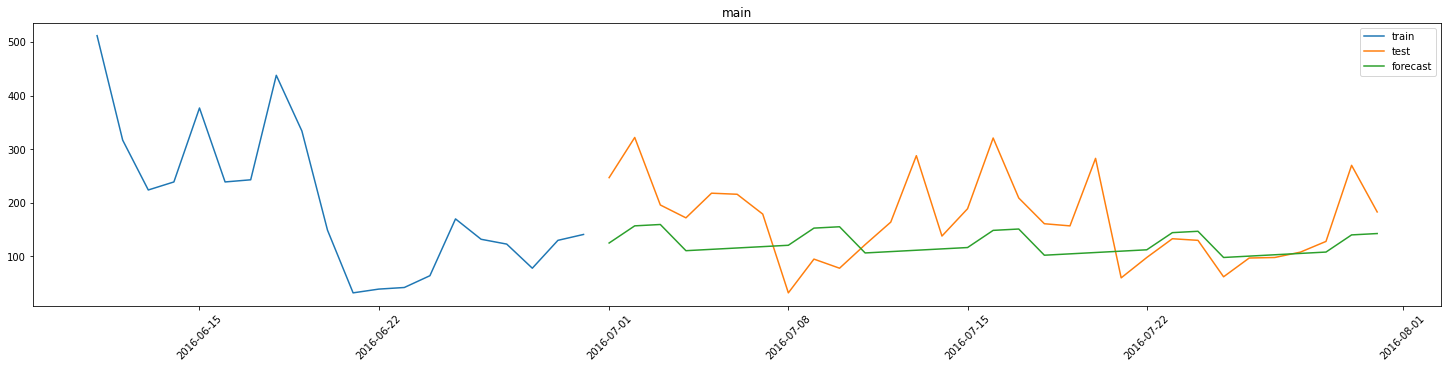

In [ ]:
from etna.models import LinearPerSegmentModel
def LinearPerSegmentModel_p(train_ts,test_ts):
  model = LinearPerSegmentModel()
  model.fit(train_ts)

#Make the forecast
  future_ts = train_ts.make_future(HORIZON)
  forecast_ts = model.forecast(future_ts)
  metric = get_metrics(forecast_ts,test_ts)
  plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=20)
  return metric
LinearPerSegmentModel_p(train_ts,test_ts)

Скользящее среднее

{'MAE': {'main': 56.35517548000948},
 'MSE': {'main': 5307.496149428185},
 'SMAPE': {'main': 36.104384319039895}}

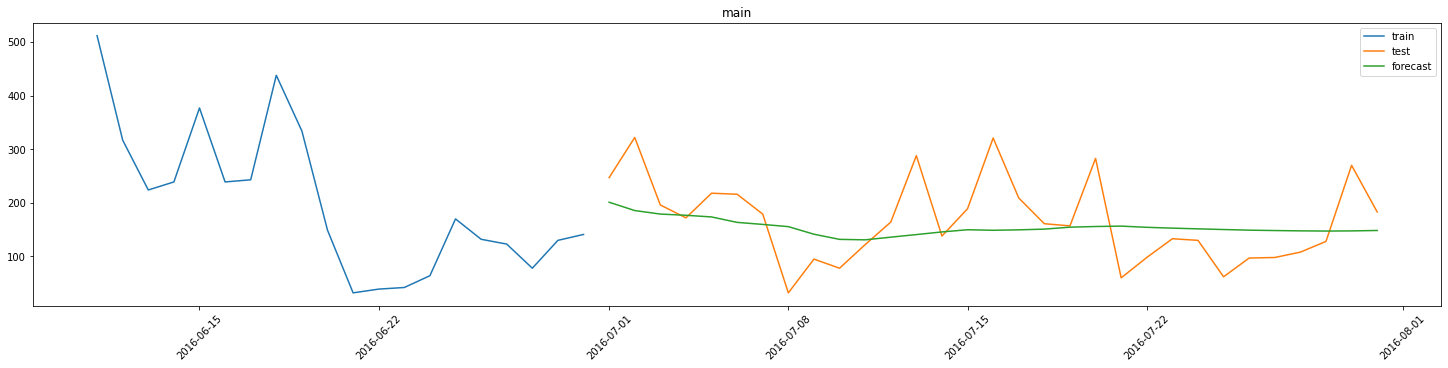

In [ ]:
from etna.models import MovingAverageModel
def MovingAverageModel_p(train_ts,test_ts):
  model = MovingAverageModel(window=20)
  model.fit(train_ts)

#Make the forecast
  future_ts = train_ts.make_future(HORIZON)
  forecast_ts = model.forecast(future_ts)
  metric = get_metrics(forecast_ts,test_ts)
  plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=20)
  return metric
MovingAverageModel_p(train_ts,test_ts)

Yandex CatBoost model (m)

{'MAE': {'main': 92.49930292595957},
 'MSE': {'main': 11770.330467294152},
 'SMAPE': {'main': 69.57664277469725}}

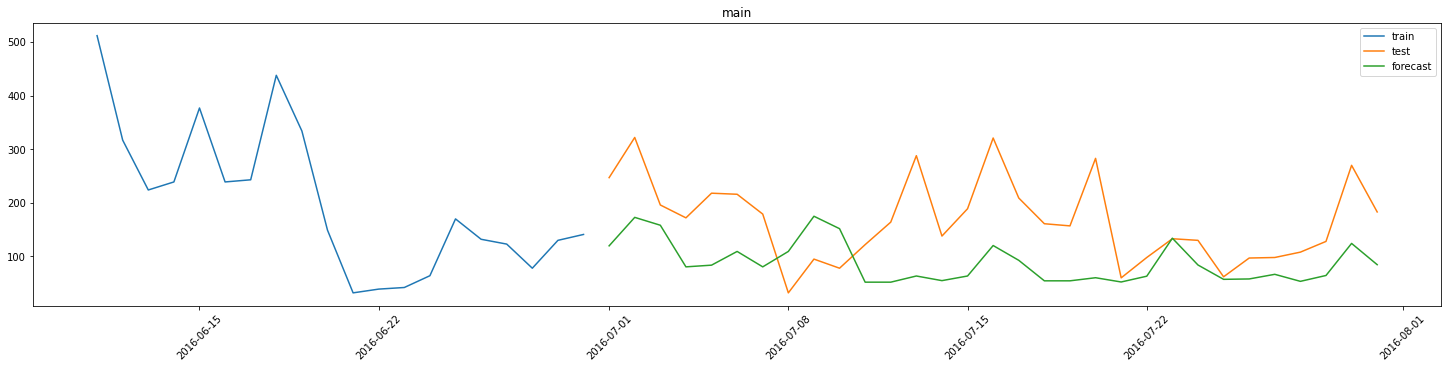

In [ ]:
from etna.models import CatBoostModelPerSegment
from etna.transforms.lags import LagTransform
def CatBoostModelPerSegment_p(train_ts,test_ts):
  model = CatBoostModelPerSegment()
  model.fit(train_ts)
  future_ts = train_ts.make_future(HORIZON)
  forecast_ts = model.forecast(future_ts)
  metric = get_metrics(forecast_ts,test_ts)
  plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=20)
  return metric
CatBoostModelPerSegment_p(train_ts,test_ts)